# Introduction to Python and Natural Language Technologies

## Lecture 11 - Dependency parsing. Universal dependencies

__December 2, 2020__

__Kinga Gémes__

In [ ]:
!python3 -m pip install stanza
!python3 -m pip install spacy
!python3 -m spacy download en_core_web_sm

In [ ]:
from IPython.display import Image

import stanza
from stanza.utils.conll import CoNLL
from stanza.models.common.doc import Document
import spacy
from spacy import displacy
import conllu
import graphviz

stanza.download('en')
nlp = stanza.Pipeline('en')
spacy_nlp = spacy.load("en_core_web_sm")

In [2]:
def visualize(parsed):
    dot = graphviz.Digraph()
    dot.node("0", "ROOT", shape="box")
    for sentence in parsed.sentences:
        for token in sentence.tokens:
            for word in token.words:
                dot.node(str(word.id), word.text)
                dot.edge(str(word.head), str(word.id),
                         label=word.deprel)
    return dot

In [3]:
def print_conllu(parsed):
    conll_sentence = CoNLL.convert_dict(parsed.to_dict())
    for sent in conll_sentence:
        for token in sent:
            print("\t".join(token))

In [4]:
def conll_to_stanza(conll):
    lines = conll.serialize().strip().split('\n')
    tokenized = [line.strip().split("\t") for line in 
                 lines if not line.startswith("#")]
    return Document(CoNLL.convert_conll([tokenized]))

# Grammar

__Why do we need it?__ Information about the syntax of the sentence can enhance our natural language models.

## Context free grammar

__Formal definition:__ 

A context-free grammar G is defined by four parameters: N, $\Sigma$, R, S.

 - N is a set of non-terminal symbols or variables

 - $\Sigma$ is a set of terminal symbols

 - R is a set of rules or productions, each in the form of A -> B, where A is a non-terminal and B is a string of symbols from ($\Sigma$ $\cup$ N)*

 - S is the designated starting symbol
 
 ### Constituency grammar

Constituency is an abstraction, where groups of words behave as units. We usually use context free grammars for modeling constituent structures.

We have the following syntactic categories (these are the non-terminals in CFG):

| Symbol | Meaning |
| :-: | :-: |
| S | sentence |
| NP | noun phrase |
| VP | verb phrase |
| PP | prepositional phrase |
| Det | determiner |
| N | noun |
| V | verb |
| P | preposition |


## Dependency graphs

Dependency structure shows which words depend on which other words in a sentence (or phrase). This is a binary asymmetric relation between a head and its dependents. The relations are typed with the grammatical relation that is between the pair of words.

The dependencies form a tree, where the head is the root of the sentence (in english this is usually the tensed verb).

A major advantage of dependency grammars is their ability to deal with languages that are morphologically rich and have a relatively free word order, which is very usefull with languages that have flexible word ordering.

A dependency tree is a directed graph that satisfies the following constraints:
 - There is a single designated root node that has no incoming arcs.
 - With the exception of the root node, each vertex has exactly one incoming arc.
 - There is a unique path from the root node to each vertex in V.

from: _Speech and Language Processing by Daniel Jurafsky and James H. Martin._

![dep](https://nlp.stanford.edu/software/stanford-dependencies/brownback-uncollapsed.png)
_Bills on ports and immigration were submitted by Senator Brownback, Republican of Kansas_

### Projectivity

__Definition:__ There are no crossing dependency arcs when the words are laid out in their linear order, with all arcs above the words.

Dependency grammars usually allow non-projective structures to account for a more free word order.

![nonprojective](img/dl/nonprojective.png)

image from: [Non-projective Dependency Parsing using Spanning Tree Algorithms by Ryan McDonald et. al.](https://www.seas.upenn.edu/~strctlrn/bib/PDF/nonprojectiveHLT-EMNLP2005.pdf)

### Syntax ambiguity

__Example:__

_One morning I shot an elephant in my pajamas. How he got into my pajamas I’ll never know._ - Groucho Marx

The ambiguity in this sentence:

is it:

 - One morning I shot an __elephant in my pajamas__

or


 - One morning __I__ shot an elephant __in my pajamas__


__CFG__

S -> NP VP

PP -> P NP

NP -> Det N | Det N PP | 'I'

VP -> V NP | VP PP

Det -> 'an' | 'my'

N -> 'elephant' | 'pajamas'

V -> 'shot' | 'saw'

P -> 'in'

![elephant1](https://www.nltk.org/book/tree_images/ch08-tree-1.png) ![elephant2](https://www.nltk.org/book/tree_images/ch08-tree-2.png)

__Dependency Grammar__

![elephant_dep1](https://www.nltk.org/book/tree_images/ch08-tree-10.png) ![elephant_dep2](https://www.nltk.org/book/tree_images/ch08-tree-11.png)

# Universal Dependencies

The structure of a sentence can be represented by a so called universal dependency (UD) graph.
The universal in the name refers to the original goal: a consistent cross-lingual grammatic annotation.

The full list of Universal Dependencies can be found on the [universal dependencies website](https://universaldependencies.org/u/dep/)

|  | Nominals | Clauses | Modifier words | Function Words |
| :-: | :-: | :-: | :-: | :-: |
| **Core arguments** | nsubj (nominal subject), obj (object), iobj (indirect object) | csubj (clausal subject), ccomp (clausal complement), xcomp (open clausal complement) |  |  |
| **Non-core dependents** | obl (oblique nominal), vocative, expl (expletive), dislocated (dislocated elements) | advcl (adverbial clause modifier) | advmod (adverbial modifier), discourse (discourse element) | aux (auxiliary), cop (copula), mark (marker) |
| **Nominal dependents** | nmod (nominal modifier), appos (appositional modifier), nummod (numeric modifier) | acl (clausal modifier of noun (adjectival clause)) | amod (adjectival modifier) | det (determiner), clf (classifier), case (case marking) |

| Coordination | MWE | Loose | Special | Other |
| :-: | :-: | :-: | :-: | :-: |
| conj (conjunct), cc (coordinating conjunction) | fixed (fixed multiword expression), flat (flat multiword expression), compound | list, parataxis | orphan, goeswith (goes with), reparandum (overridden disfluency) | punct (punctuation), root, dep (unspecified dependency) |


## CoNLL-U format

| ID | FORM | LEMMA | UPOS | XPOS | FEATS | HEAD | DEPREL | DEPS | MISC |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| Word index, integer starting at 1 for each new sentence; may be a range for multiword tokens; may be a decimal number for empty nodes (decimal numbers can be lower than 1 but must be greater than 0). | Word form or punctuation symbol. | Lemma or stem of word form. | Universal part-of-speech tag. | Language-specific part-of-speech tag; underscore if not available. | List of morphological features from the universal feature inventory or from a defined language-specific extension; underscore if not available. | Head of the current word, which is either a value of ID or zero (0). | Universal dependency relation to the HEAD (root iff HEAD = 0) or a defined language-specific subtype of one. | Enhanced dependency graph in the form of a list of head-deprel pairs. | Any other annotation. |

Example:

| ID | FORM | LEMMA | UPOS | XPOS | FEATS | HEAD | DEPREL | DEPS | MISC |
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
| 1 | They | they | PRON | PRP | Case=Nom\|Number=Plur | 2 | nsubj | 2:nsubj\|4:nsubj | _ |
| 2 | buy | buy | VERB | VBP | Number=Plur\|Person=3\|Tense=Pres | 0 | root | 0:root | _ |
| 3 | and | and | CONJ | CC | _ | 4 | cc | 4:cc | _ |
| 4 | sell | sell | VERB | VBP | Number=Plur\|Person=3\|Tense=Pres | 2 | conj | 0:root\|2:conj | _ |
| 5 | books | book | NOUN | NNS | Number=Plur | 2 | obj | 2:obj\|4:obj | SpaceAfter=No |
| 6 | . | . | PUNCT | . | _ | 2 | punct | 2:punct | _ |


from https://universaldependencies.org/format.html


# UD Treebanks

We use UD Treebanks to train models that can predict the UD structure of sentences. There are 183 treebanks and 104 languages in version 2.7, which came out November 15, 2020.

In [ ]:
!curl --remote-name-all https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-3424{/ud-treebanks-v2.7.tgz,/ud-documentation-v2.7.tgz,/ud-tools-v2.7.tgz}

In [ ]:
!mkdir ud_treebanks
!tar -xvzf ud-treebanks-v2.7.tgz -C ./ud_treebanks

In [7]:
en = "ud_treebanks/ud-treebanks-v2.7/UD_English-EWT/en_ewt-ud-train.conllu"
with open(en) as english:
    trees = conllu.parse(english.read())

In [8]:
index = 88
trees[index].metadata["text"]

'These links present the many viewpoints that existed and still exist about the disaster called Chernobyl:'

In [9]:
print(trees[index].serialize())

# sent_id = weblog-typepad.com_ripples_20040407125600_ENG_20040407_125600-0024
# text = These links present the many viewpoints that existed and still exist about the disaster called Chernobyl:
1	These	this	DET	DT	Number=Plur|PronType=Dem	2	det	2:det	_
2	links	link	NOUN	NNS	Number=Plur	3	nsubj	3:nsubj	_
3	present	present	VERB	VBP	Mood=Ind|Tense=Pres|VerbForm=Fin	0	root	0:root	_
4	the	the	DET	DT	Definite=Def|PronType=Art	6	det	6:det	_
5	many	many	ADJ	JJ	Degree=Pos	6	amod	6:amod	_
6	viewpoints	viewpoint	NOUN	NNS	Number=Plur	3	obj	3:obj|8:nsubj|11:nsubj	_
7	that	that	PRON	WDT	PronType=Rel	8	nsubj	6:ref	_
8	existed	exist	VERB	VBD	Mood=Ind|Tense=Past|VerbForm=Fin	6	acl:relcl	6:acl:relcl	_
9	and	and	CCONJ	CC	_	11	cc	11:cc	_
10	still	still	ADV	RB	_	11	advmod	11:advmod	_
11	exist	exist	VERB	VBP	Mood=Ind|Tense=Pres|VerbForm=Fin	8	conj	6:acl:relcl|8:conj:and	_
12	about	about	ADP	IN	_	14	case	14:case	_
13	the	the	DET	DT	Definite=Def|PronType=Art	14	det	14:det	_
14	disaster	disaster	NOUN	NN	Number

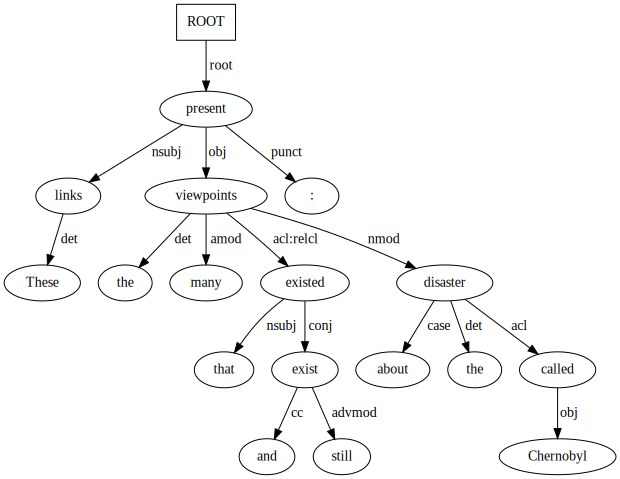

In [10]:
visualize(conll_to_stanza(trees[index]))

# Dependency parsing

Dependency parsing is the task of transforming a sentence into its corresponding dependency tree.

We have two steps to be done:

 - Construct a model based on training sentences and their respective dependency trees, that can be used to parse other sentences the same way.
 - Given this model, find the most optimal dependency tree for the given sentence.

__Possible solutions:__

 - Graph Based Dependency Parsing
 - Transition-Based Dependency Parsing
 - Neural Dependency Parsing
   - Neural graph-based parser
   - Neural transition-based parser

__Evaluation metrics:__

 - Labeled attachment score (LAS): the percentage of words that are assigned both the correct syntactic head and the correct dependency label
 - Unlabeled attachment score (UAS): the percentage of words that are assigned both the correct syntactic head


__What do we use dependency parsing for?__

 - Relation and information extraction
 - Coreference or anaphora resolution
 - Synonym generation
 - Semantic parsing
 - Question answering

### Graph Based Dependency Parsing

Graph-based methods for creating dependency structures are based on the use of maximum spanning tree methods.

1. Connect every word in a sentence with dependencies
2. Every dependency is an edge
3. Score each edge independently (usually using some ML method)
4. Find maximum spanning tree using the Chu-Liu-Edmonds algorithm
   1. Contracting Stage
       1. Find the best incoming edge for each node in the graph.
       2. If a cycle is formed, merge the nodes into a new node.
   2. Expanding Stage
       1. Every contracted node will have exactly one best incoming edge, kicking out the others. There is no need for that contraction anymore.

### Transition-Based Dependency Parsing

Transition-based parsing systems employ a greedy stack-based algorithm called shift-reduce to create dependency structures.

 1. We initialize a state with input configuration, which consists of a stack, an input buffer of tokens, and a set of relations.
 2. We go through the possible configurations using a sequence of transition operations.
 3. We stop the iteration if we reached the final state.
 
Transitions in shift-reduce parsing (a popular solution for transitions):
 - $Shift$: Remove the first word in the buffer and push it on top of the stack.
 - $Left-Arc_r$: Add a dependency arc (wj, r, wi) to the arc set A, where wi is the word second to the top of the stack and wj is the word at the top of the stack. Remove wi from the stack.
 - $Right-Arc_r$: Add a dependency arc (wi, r, wj) to the arc set A, where wi is the word second to the top of the stack and wj is the word at the top of the stack. Remove wj from the stack.


### Example

In [11]:
simple_sentence = "I like apples"

__Chu-Liu-Edmonds__

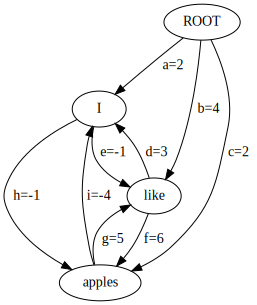

In [12]:
apple = graphviz.Digraph()
apple.edge("ROOT", "I", label="a=2")
apple.edge("ROOT", "like", label="b=4")
apple.edge("ROOT", "apples", label="c=2")
apple.edge("like", "I", label="d=3")
apple.edge("I", "like", label="e=-1")
apple.edge("like", "apples", label="f=6")
apple.edge("apples", "like", label="g=5")
apple.edge("I", "apples", label="h=-1")
apple.edge("apples", "I", label="i=-4")
apple

| Node | Best in edge |
| :-: | :-: |
| I | d |
| like | g |
| apples | f |

We need contraction! like + apples => l_a

| Edge | Kicks out |
| :-: | :-: |
| a |  |
| b | g |
| c | f |
| d |  |
| e | g |
| f |  |
| g |  |
| h | f |
| i |  |

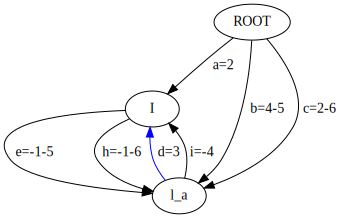

In [13]:
apple = graphviz.Digraph()
apple.edge("ROOT", "I", label="a=2")
apple.edge("ROOT", "l_a", label="b=4-5")
apple.edge("ROOT", "l_a", label="c=2-6")
apple.edge("l_a", "I", label="d=3", color="blue")
apple.edge("I", "l_a", label="e=-1-5")
apple.edge("I", "l_a", label="h=-1-6")
apple.edge("l_a", "I", label="i=-4")
apple

| Node | Best in edge |
| :-: | :-: |
| I | d |
| like | g |
| apples | f |
| l_a | __b__ |

We no longer need contraction! l_a => like + apples

| Edge | Kicks out |
| :-: | :-: |
| a |  |
| b | __g__ |
| c | f |
| d |  |
| e | g |
| f |  |
| g |  |
| h | f |
| i |  |

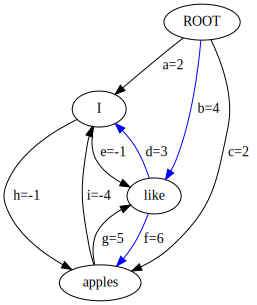

In [14]:
apple = graphviz.Digraph()
apple.edge("ROOT", "I", label="a=2")
apple.edge("ROOT", "like", label="b=4", color="blue")
apple.edge("ROOT", "apples", label="c=2")
apple.edge("like", "I", label="d=3", color="blue")
apple.edge("I", "like", label="e=-1")
apple.edge("like", "apples", label="f=6", color="blue")
apple.edge("apples", "like", label="g=5")
apple.edge("I", "apples", label="h=-1")
apple.edge("apples", "I", label="i=-4")
apple

__Shift-reduce__

|   | Stack | Buffer | Transition |
| :-: | :-: | :-: | :-: |
| 1 | root | I, like, apples | SHIFT |
| 2 | root, I | like, apples | SHIFT |
| 3 | root, I, like | apples | LEFT-ARC |
| 4 | root, like | apples | SHIFT |
| 5 | root, like, apples |  | RIGHT-ARC |
| 6 | root, like |  | RIGHT-ARC |

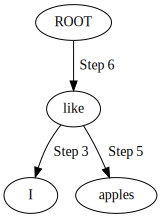

In [15]:
apple = graphviz.Digraph()
apple.edge("like", "I", label="Step 3")
apple.edge("like", "apples", label="Step 5")
apple.edge("ROOT", "like", label="Step 6")
apple

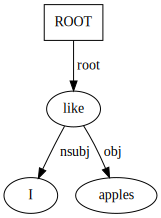

In [16]:
visualize(nlp("I like apples"))

### Neural Dependency Parsing

Usually builds on transition based or graph based approach.
![neural-transition](img/dl/neural-transition.png)
Model from [A Fast and Accurate Dependency Parser using Neural Networks by Danqi Chen and Christopher D. Manning](https://nlp.stanford.edu/pubs/emnlp2014-depparser.pdf)

![neural-graph](img/dl/neural-graph.png)
Model from [Deep Biaffine Attention for Neural Dependency Parsing by Timothy Dozat and Christopher D. Manning](https://arxiv.org/pdf/1611.01734.pdf)

## Pretrained dependency parsers - [Spacy](https://spacy.io)

spaCy is a diverse python library that can handle multiple NLP tasks - one of which is dependency parsing. It supports 10 languages and has its own visualization tool.

In [17]:
sentence = "One morning I shot an elephant in my pajamas."
#sentence = trees[index].metadata["text"]

In [18]:
doc = spacy_nlp(sentence)
for token in doc:
    print(f"{token.text}\t{token.dep_}\t{token.head.text}\t"+
          f"{token.head.pos_}\t{[child for child in token.children]}")

One	nummod	morning	NOUN	[]
morning	npadvmod	shot	VERB	[One]
I	nsubj	shot	VERB	[]
shot	ROOT	shot	VERB	[morning, I, elephant, in, .]
an	det	elephant	NOUN	[]
elephant	dobj	shot	VERB	[an]
in	prep	shot	VERB	[pajamas]
my	poss	pajamas	NOUN	[]
pajamas	pobj	in	ADP	[my]
.	punct	shot	VERB	[]


In [19]:
displacy.serve(doc, style="dep")

/home/kinga/.local/lib/python3.8/site-packages/spacy/displacy/__init__.py:94: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'dep' visualizer
Serving on http://0.0.0.0:5000 ...

Shutting down server on port 5000.


## Pretrained dependency parsers - Stanza

Stanza is an [NLP package](https://stanfordnlp.github.io/stanza/) created by [Peng Qi, Yuhao Zhang, Yuhui Zhang, Jason Bolton and Christopher D. Manning in 2020](https://arxiv.org/pdf/2003.07082.pdf) for tokenization, lemmatization, sentiment analysis, POS and NER tagging, and dependency parsing. It has pretrained models for [66 languages](https://stanfordnlp.github.io/stanza/available_models.html) and uses the UD formalism.

It uses the afromentioned [Bi-LSTM-based deep biaffine neuraldependency parser](https://arxiv.org/pdf/1611.01734.pdf) for dependency parsing.

![stanza](https://stanfordnlp.github.io/stanza/assets/images/pipeline.png)

In [20]:
parsed = nlp(sentence)

In [21]:
print_conllu(parsed)

1	One	one	NUM	CD	NumType=Card	2	nummod	_	start_char=0|end_char=3
2	morning	morning	NOUN	NN	Number=Sing	4	obl:tmod	_	start_char=4|end_char=11
3	I	I	PRON	PRP	Case=Nom|Number=Sing|Person=1|PronType=Prs	4	nsubj	_	start_char=12|end_char=13
4	shot	shoot	VERB	VBD	Mood=Ind|Tense=Past|VerbForm=Fin	0	root	_	start_char=14|end_char=18
5	an	a	DET	DT	Definite=Ind|PronType=Art	6	det	_	start_char=19|end_char=21
6	elephant	elephant	NOUN	NN	Number=Sing	4	obj	_	start_char=22|end_char=30
7	in	in	ADP	IN	_	9	case	_	start_char=31|end_char=33
8	my	my	PRON	PRP$	Number=Sing|Person=1|Poss=Yes|PronType=Prs	9	nmod:poss	_	start_char=34|end_char=36
9	pajamas	pajama	NOUN	NNS	Number=Plur	4	obl	_	start_char=37|end_char=44
10	.	.	PUNCT	.	_	4	punct	_	start_char=44|end_char=45


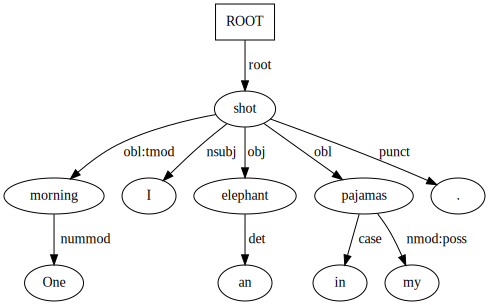

In [22]:
visualize(parsed)

# Further reading

[Speech and Language Processing by Daniel Jurafsky, and James H. Martin.](https://web.stanford.edu/~jurafsky/slp3/)

[Natural Language Processing with Python - Analyzing Text with the Natural Language Toolkit by Steven Bird, Ewan Klein, and Edward Loper](https://www.nltk.org/book/)

[Deep Biaffine Attention for Neural Dependency Parsing by Timothy Dozat and Christopher D. Manning](https://arxiv.org/pdf/1611.01734.pdf)